In [1]:
from __future__ import print_function

import os
import numpy as np
import pandas as pd
import seaborn as sns

from tqdm import *
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from keras.models import Model
from keras.utils import np_utils
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers import Dense, Dropout, Activation, Flatten, Input

%matplotlib inline

Using TensorFlow backend.


In [2]:
dataset_path = '../mfccs/13/'
cls_list = ['blues',
            'classical',
            'country',
            'disco',
            'hiphop',
            'jazz',
            'metal',
            'pop',
            'reggae',
            'rock']

### Data loading and preparation

In [3]:
X = []
y = []

for cls in tqdm(os.listdir(dataset_path)):
    cls_path = os.path.join(dataset_path, cls)
    
    for f in os.listdir(cls_path):
        X.append(pd.read_csv(os.path.join(cls_path, f), delimiter=';', header=None).iloc[:, :-1])
        y.append(cls_list.index(cls))

100%|██████████| 10/10 [00:07<00:00,  1.41it/s]


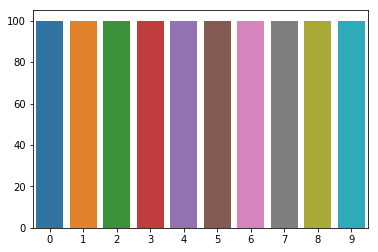

In [4]:
y_np = np.asarray(y)
v, c = np.unique(y_np, return_counts=True)
sns.barplot(v, c)

#### MFCC simplification
Each audio has 13 MFCCs per frame. We are simplifying it by computing the mean of the frames and using the resulting single vector of 13 MFCCs as the audio representation.

In [5]:
X_std = []

for idx, i in tqdm(enumerate(X)):
    X_std.append(np.mean(i, axis=0))

1000it [00:00, 2244.10it/s]


In [6]:
X_std = np.asarray(X_std)
print(X_std.shape, X_std.dtype)

(1000, 13) float64


#### Train/Val split

In [7]:
X_train, X_val, y_train, y_val = train_test_split(X_std, y_np, test_size=0.33, random_state=33, stratify=y_np)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(670, 13) (330, 13) (670,) (330,)


In [8]:
y_train = np_utils.to_categorical(y_train)
y_val = np_utils.to_categorical(y_val)
print(y_train.shape, y_val.shape)

(670, 10) (330, 10)


In [9]:
def create_model():
    inp = Input(shape=(X_train.shape[1],))
    x = Dense(64)(inp)
    x = Activation('relu')(x)

    x = Dense(10)(x)
    x = Activation('softmax')(x)

    model = Model(inputs=inp, outputs=x)
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
    return model

In [10]:
model = create_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 13)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                896       
_________________________________________________________________
activation_1 (Activation)    (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                650       
_________________________________________________________________
activation_2 (Activation)    (None, 10)                0         
Total params: 1,546.0
Trainable params: 1,546.0
Non-trainable params: 0.0
_________________________________________________________________


#### Normalization

In [11]:
X_train_means = X_train.mean(axis=0)
X_train_stds = X_train.std(axis=0)

print('Means:', X_train_means)
print('Stds:', X_train_stds)

Means: [-650.6297977   133.04630026   -6.57415915   34.46168699   -3.30174185
   12.07065647   -7.9906482    10.0232402    -8.30882395    7.52375389
   -6.85239181    4.18318983   -5.18664802]
Stds: [101.02985116  36.1597846   24.5315318   20.24361409  12.1117232
  13.29301     10.08719245  10.236978     7.8850999    7.24217957
   6.96274209   5.67676019   5.68651412]


In [12]:
X_train -= X_train_means
X_train /= X_train_stds

print('Means:', X_train.mean(axis=0))
print('Std:', X_train.std(axis=0))

Means: [-3.91063633e-15  3.09304821e-15 -1.77469979e-16  1.09680093e-15
 -1.65870634e-16 -7.98987742e-16  7.04908768e-16  9.56780260e-16
 -2.13179391e-16  1.39988560e-15  1.17683641e-15  8.07811529e-17
 -2.43669098e-16]
Std: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [13]:
X_val -= X_train_means
X_val /= X_train_stds

In [14]:
model = create_model()
history = model.fit(X_train, y_train,
                    batch_size=32,
                    epochs=100, 
                    validation_data=(X_val, y_val))

Train on 670 samples, validate on 330 samples
Epoch 1/100
670/670 [==============================] - 1s - loss: 2.2455 - acc: 0.1537 - val_loss: 2.1161 - val_acc: 0.2333
Epoch 2/100
670/670 [==============================] - 0s - loss: 2.0196 - acc: 0.3075 - val_loss: 1.9425 - val_acc: 0.3424
Epoch 3/100
670/670 [==============================] - 0s - loss: 1.8712 - acc: 0.3776 - val_loss: 1.8230 - val_acc: 0.3818
Epoch 4/100
670/670 [==============================] - 0s - loss: 1.7650 - acc: 0.4045 - val_loss: 1.7384 - val_acc: 0.3970
Epoch 5/100
670/670 [==============================] - 0s - loss: 1.6843 - acc: 0.4164 - val_loss: 1.6760 - val_acc: 0.4000
Epoch 6/100
670/670 [==============================] - 0s - loss: 1.6193 - acc: 0.4478 - val_loss: 1.6247 - val_acc: 0.4121
Epoch 7/100
670/670 [==============================] - 0s - loss: 1.5637 - acc: 0.4552 - val_loss: 1.5804 - val_acc: 0.4212
Epoch 8/100
670/670 [==============================] - 0s - loss: 1.5145 - acc: 0.4657

670/670 [==============================] - 0s - loss: 0.7997 - acc: 0.7328 - val_loss: 1.2993 - val_acc: 0.5909
Epoch 67/100
670/670 [==============================] - 0s - loss: 0.7962 - acc: 0.7313 - val_loss: 1.2975 - val_acc: 0.5758
Epoch 68/100
670/670 [==============================] - 0s - loss: 0.7893 - acc: 0.7418 - val_loss: 1.3057 - val_acc: 0.5848
Epoch 69/100
670/670 [==============================] - 0s - loss: 0.7857 - acc: 0.7403 - val_loss: 1.3036 - val_acc: 0.5818
Epoch 70/100
670/670 [==============================] - 0s - loss: 0.7806 - acc: 0.7373 - val_loss: 1.3021 - val_acc: 0.5909
Epoch 71/100
670/670 [==============================] - 0s - loss: 0.7766 - acc: 0.7403 - val_loss: 1.3060 - val_acc: 0.5879
Epoch 72/100
670/670 [==============================] - 0s - loss: 0.7732 - acc: 0.7418 - val_loss: 1.3089 - val_acc: 0.5848
Epoch 73/100
670/670 [==============================] - 0s - loss: 0.7701 - acc: 0.7418 - val_loss: 1.3077 - val_acc: 0.5909
Epoch 74/100


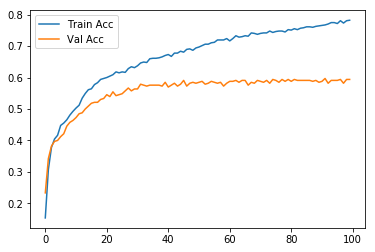

In [15]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['Train Acc', 'Val Acc'])

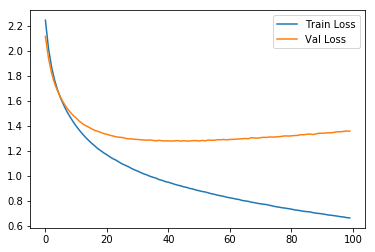

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train Loss', 'Val Loss'])

In [17]:
y_train_pred = model.predict(X_train)
y_train_pred_max = np.argmax(y_train_pred, axis=1)
y_train_max = np.argmax(y_train, axis=1)

print('Train')
print(classification_report(y_train_max, y_train_pred_max))

Train
              precision    recall  f1-score   support

           0       0.84      0.81      0.82        67
           1       0.94      0.99      0.96        67
           2       0.80      0.70      0.75        67
           3       0.66      0.72      0.69        67
           4       0.68      0.60      0.63        67
           5       0.84      0.79      0.82        67
           6       0.78      0.91      0.84        67
           7       0.85      0.99      0.91        67
           8       0.74      0.75      0.74        67
           9       0.72      0.63      0.67        67

   micro avg       0.79      0.79      0.79       670
   macro avg       0.78      0.79      0.78       670
weighted avg       0.78      0.79      0.78       670



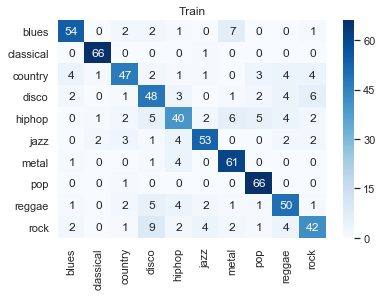

In [18]:
cm = confusion_matrix(y_train_max, y_train_pred_max)
sns.set()
plt.figure()
plt.title('Train')
sns.heatmap(cm, annot=True, yticklabels=cls_list, xticklabels=cls_list, cmap='Blues')

In [19]:
y_pred = model.predict(X_val)
y_pred_max = np.argmax(y_pred, axis=1)
y_max = np.argmax(y_val, axis=1)

print('Val')
print(classification_report(y_max, y_pred_max))

Val
              precision    recall  f1-score   support

           0       0.75      0.64      0.69        33
           1       0.78      0.88      0.83        33
           2       0.56      0.58      0.57        33
           3       0.45      0.42      0.44        33
           4       0.47      0.52      0.49        33
           5       0.50      0.52      0.51        33
           6       0.86      0.76      0.81        33
           7       0.66      0.70      0.68        33
           8       0.47      0.52      0.49        33
           9       0.47      0.42      0.44        33

   micro avg       0.59      0.59      0.59       330
   macro avg       0.60      0.59      0.59       330
weighted avg       0.60      0.59      0.59       330



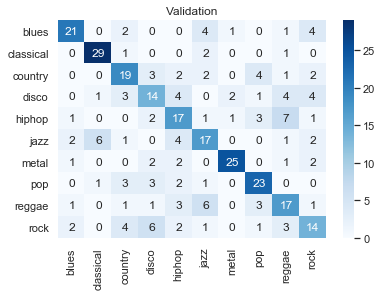

In [20]:
cm = confusion_matrix(y_max, y_pred_max)
sns.set()
plt.figure()
plt.title('Validation')
sns.heatmap(cm, annot=True, yticklabels=cls_list, xticklabels=cls_list, cmap='Blues')